In [22]:
!pip install opencv-python
!pip install scikit-image
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt


1) For two plant images (plant_002, plant_005), you are required to put the original images, segmented plant image, the calculated DS value for each of the two images, and the detected leaf image and counting the number of leaves. Please note for the leaf detection you are not required to properly segment all the leaves, you can use bounding box to show the location of each leaf; 

DS value for plant002_rgb.png: 0.24
Number of leaves in plant002_rgb.png: 100


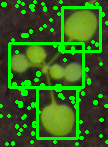

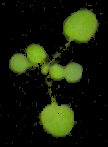

DS value for plant005_rgb.png: 0.31
Number of leaves in plant005_rgb.png: 51


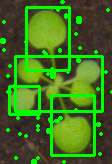

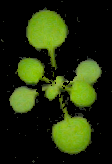

In [26]:


def calculate_ds(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv_image, (36, 25, 25), (86, 255, 255))
    green_pixels = cv2.countNonZero(green_mask)
    total_pixels = image.shape[0] * image.shape[1]
    ds = green_pixels / total_pixels
    return ds

def detect_leaves(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv_image, (36, 25, 25), (86, 255, 255))
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    leaves = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        leaves.append((x, y, w, h))

    return leaves

# Load and process the two specific plant images (plant_002 and plant_005)
folder_name = '/content/drive/MyDrive/plant images'
images = [
    "plant001_rgb.png",
    "plant002_rgb.png",
    "plant003_rgb.png",
    "plant004_rgb.png",
    "plant005_rgb.png",
    "plant006_rgb.png",
    "plant007_rgb.png",
    "plant008_rgb.png",
    "plant009_rgb.png",
    "plant010_rgb.png",
    "plant011_rgb.png",
    "plant012_rgb.png",
    "plant013_rgb.png",
    "plant014_rgb.png",
    "plant015_rgb.png",
    "plant016_rgb.png",
]




from google.colab.patches import cv2_imshow

# Loop through the two specific plant images
for i, image_name in enumerate(["plant002_rgb.png", "plant005_rgb.png"], start=1):
    image_path = f"{folder_name}/{image_name}"
    image = cv2.imread(image_path)

    # Calculate DS value
    ds = calculate_ds(image)
    print(f"DS value for {image_name}: {ds:.2f}")

    # Segment plant image
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv_image, (36, 25, 25), (86, 255, 255))
    segmented_image = cv2.bitwise_and(image, image, mask=green_mask)

    # Detect leaves
    leaves = detect_leaves(image)
    num_leaves = len(leaves)
    print(f"Number of leaves in {image_name}: {num_leaves}")

    # Draw bounding boxes for the leaves on the original image
    for x, y, w, h in leaves:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display images
    cv2_imshow(image)
    cv2_imshow(segmented_image)


 2) for all the 16 plant images, please provide a bar graph with x-axis representing the number of the image, and y-axis representing the corresponding DS. 

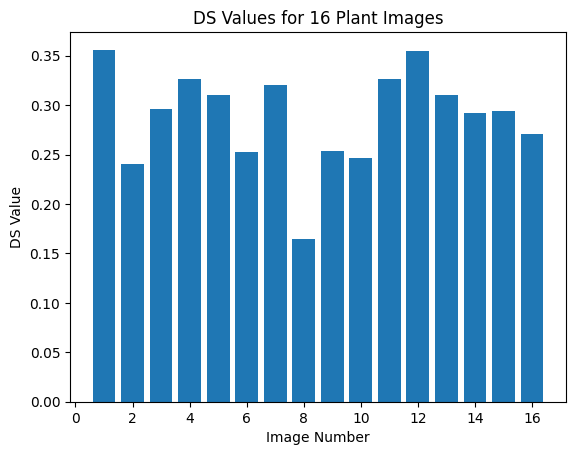

In [27]:
from google.colab.patches import cv2_imshow

# Calculate and store DS values for all 16 plant images
ds_values = []
for image_name in images:
    image_path = f"{folder_name}/{image_name}"
    image = cv2.imread(image_path)
    ds = calculate_ds(image)
    ds_values.append(ds)

# Plot bar graph
plt.bar(range(1, len(ds_values) + 1), ds_values)
plt.xlabel('Image Number')
plt.ylabel('DS Value')
plt.title('DS Values for 16 Plant Images')
plt.show()


Calculate the mean of the DS for all the 16 images

In [28]:
# Calculate mean of DS values
mean_ds = np.mean(ds_values)
print(f"Mean DS value: {mean_ds:.2f}")


Mean DS value: 0.29


 Leaf detection performance evaluation.

In [30]:
# True positive: correctly detected leaves
# False positive: wrongly detected leaves
# False negative: missed leaves

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area
    return iou


def evaluate_leaf_detection(true_leaves, detected_leaves):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for true_leaf in true_leaves:
        found_match = False
        for detected_leaf in detected_leaves:
            iou = calculate_iou(true_leaf, detected_leaf)
            if iou >= 0.5:  # Consider it a match if IoU is above a threshold (e.g., 0.5)
                true_positives += 1
                found_match = True
                break

        if not found_match:
            false_negatives += 1

    false_positives = len(detected_leaves) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

# Example usage
true_leaves = [(10, 10, 20, 20), (30, 30, 25, 25), (50, 50, 15, 15)]  # Ground truth leaves
detected_leaves = [(8, 8, 21, 21), (30, 30, 26, 26), (55, 55, 12, 12), (70, 70, 20, 20)]  # Detected leaves

precision, recall, f1_score = evaluate_leaf_detection(true_leaves, detected_leaves)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


Precision: 0.50
Recall: 0.67
F1 Score: 0.57


In [45]:
def segment_plant(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a median blur to reduce noise
    blurred_image = cv2.medianBlur(gray_image, 5)

    # Apply adaptive thresholding to create a binary image
    thresh_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply morphological opening to remove small objects and smooth edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opened_image = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, kernel)

    # Apply morphological closing to fill holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

    # Find contours in the image
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a black mask image of the same size as the original image
    mask = np.zeros_like(gray_image)

    # Draw the largest contour on the mask
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], 0, (255,255,255), -1)

    return mask


Please provide a Table showing the absolute difference of the automated leaf counts (multiple detections of the same leaf should count one) and the actual number of leaves provided in the csv file for each image, calculate the mean of the differences in leaf counts over all the 16 images

In [56]:
import cv2
import os
import csv
from tabulate import tabulate


# Path to the image folder
image_folder = "/content/drive/MyDrive/plant images"

# Load leaf counts from the CSV file
csv_file = '/content/drive/MyDrive/leaf_counts.csv'
leaf_counts = {}

with open(csv_file, 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        plant_name = row['Plant']
        leaf_count = int(row['values'])
        leaf_counts[plant_name] = leaf_count

# Create a table to store the results
table = [["Image", "Automated Leaf Count", "Actual Leaf Count", "Difference"]]

# Initialize variables for mean calculation
total_difference = 0
num_images = 0

# Iterate over each image in the folder
for i in range(1, 17):
    # Read the input image
    image_file = os.path.join(image_folder, f"plant{i:03d}_rgb.png")
    print(f"Processing image {i}...")
    print("Image file:", image_file)

    input_image = cv2.imread(image_file)

    if input_image is None:
        print(f"Failed to load image: {image_file}")
        continue

    # Perform leaf counting
    automated_leaf_count = count_leaves(input_image)

    # Get the actual leaf count from the CSV file
    plant_name = f"plant{i:03d}"
    actual_leaf_count = leaf_counts.get(plant_name, 0)

    # Calculate the absolute difference in leaf counts
    difference = abs(automated_leaf_count - actual_leaf_count)

    # Update variables for mean calculation
    total_difference += difference
    num_images += 1

    # Add the results to the table
    table.append([plant_name, automated_leaf_count, actual_leaf_count, difference])

# Calculate the mean difference
mean_difference = total_difference / num_images

# Print the table
print(tabulate(table, headers="firstrow", tablefmt="grid"))

# Print the mean difference
print("Mean Difference:", mean_difference)


Processing image 1...
Image file: /content/drive/MyDrive/plant images/plant001_rgb.png
Processing image 2...
Image file: /content/drive/MyDrive/plant images/plant002_rgb.png
Processing image 3...
Image file: /content/drive/MyDrive/plant images/plant003_rgb.png
Processing image 4...
Image file: /content/drive/MyDrive/plant images/plant004_rgb.png
Processing image 5...
Image file: /content/drive/MyDrive/plant images/plant005_rgb.png
Processing image 6...
Image file: /content/drive/MyDrive/plant images/plant006_rgb.png
Processing image 7...
Image file: /content/drive/MyDrive/plant images/plant007_rgb.png
Processing image 8...
Image file: /content/drive/MyDrive/plant images/plant008_rgb.png
Processing image 9...
Image file: /content/drive/MyDrive/plant images/plant009_rgb.png
Processing image 10...
Image file: /content/drive/MyDrive/plant images/plant010_rgb.png
Processing image 11...
Image file: /content/drive/MyDrive/plant images/plant011_rgb.png
Processing image 12...
Image file: /conte